In [1]:
import os
import zipfile
import numpy as np
import librosa
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# Step 1: Extract the ZIP dataset
dataset_path = '/content/drive/MyDrive/Colab Notebooks/cnn_speech_dataset.zip'
extracted_path = '/mnt/data/cnn_speech_dataset'

with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_path)

# Step 2: Load and preprocess audio files
def extract_features(file_path, max_len=100):
    y, sr = librosa.load(file_path, sr=16000)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    # Pad or truncate
    if mfccs.shape[1] < max_len:
        pad_width = max_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, ((0, 0), (0, pad_width)), mode='constant')
    else:
        mfccs = mfccs[:, :max_len]
    return mfccs

X = []
y = []

# Assumes structure like: extracted_path/emotion_label/filename.wav
for root, dirs, files in os.walk(extracted_path):
    for file in files:
        if file.endswith('.wav'):
            label = os.path.basename(root)
            file_path = os.path.join(root, file)
            features = extract_features(file_path)
            X.append(features)
            y.append(label)

X = np.array(X)
X = X[..., np.newaxis]  # Add channel dimension
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

# Step 3: Build CNN model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=X_train.shape[1:]),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(y_categorical.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Step 4: Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Step 5: Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.2f}")

# Optional: Plot accuracy
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


ValueError: zero-size array to reduction operation maximum which has no identity

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Epoch 1/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 118s 129ms/step - accuracy: 0.2540 - loss: 1.7982 - val_accuracy: 0.3781 - val_loss: 1.5807
Epoch 2/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 115s 128ms/step - accuracy: 0.3757 - loss: 1.6042 - val_accuracy: 0.4270 - val_loss: 1.4546
Epoch 3/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 116s 130ms/step - accuracy: 0.4275 - loss: 1.4923 - val_accuracy: 0.4629 - val_loss: 1.3885
Epoch 4/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 119s 133ms/step - accuracy: 0.4626 - loss: 1.4077 - val_accuracy: 0.5096 - val_loss: 1.2879
Epoch 5/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 117s 130ms/step - accuracy: 0.4806 - loss: 1.3664 - val_accuracy: 0.5142 - val_loss: 1.2646
Epoch 6/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 116s 129ms/step - accuracy: 0.4915 - loss: 1.3341 - val_accuracy: 0.5266 - val_loss: 1.2382
Epoch 7/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 116s 129ms/step - accuracy: 0.5052 - loss: 1.3124 - val_accuracy: 0.5308 - val_loss

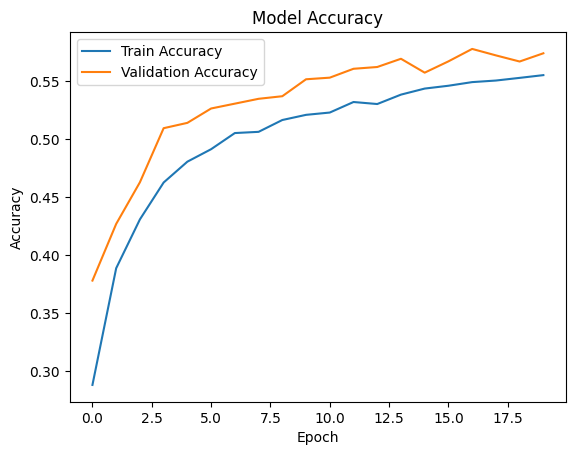

In [2]:
import os
import zipfile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Step 1: Extract zip file
zip_path = '/content/drive/MyDrive/Colab Notebooks/cnn_speech_dataset.zip'  # Your uploaded ZIP
extract_path = '/content/data/emotion_dataset'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Paths to train and test directories
train_dir = os.path.join(extract_path, 'train')
test_dir = os.path.join(extract_path, 'test')

# Step 2: Set up image data generators
img_size = (48, 48)  # Common for facial expression datasets
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale'  # assuming grayscale emotion images
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale'
)

# Step 3: Build CNN model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Step 4: Train the model
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=test_generator
)

# Step 5: Evaluate model
loss, acc = model.evaluate(test_generator)
print(f"Test Accuracy: {acc:.2f}")

# Step 6: Plot training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [3]:
model.save("emotion_cnn_model.h5")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


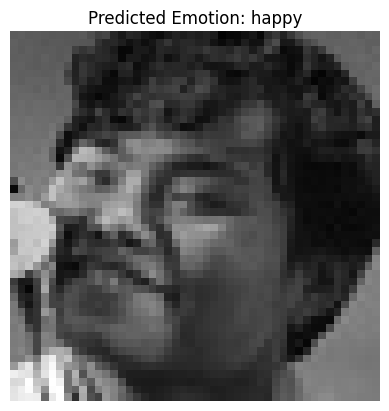

Predicted Emotion: happy


In [7]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# === Step 1: Load the trained model (.h5 file) ===
model = load_model('/content/emotion_cnn_model.h5')  # Make sure the file is in the same directory

# === Step 2: Define the emotion labels (same order as during training) ===
class_labels = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']  # Modify if different

# === Step 3: Load and preprocess the new image ===
# Replace this path with your test image path
img_path = '/content/data/emotion_dataset/test/happy/PrivateTest_10470092.jpg'

# Load image (grayscale or RGB depending on model)
# Check if the image file exists
if not os.path.exists(img_path):
    print(f"Error: Image file not found at {img_path}")
    # Handle the error, e.g., exit the script or use a default image
else:
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Use IMREAD_COLOR if trained with color images

    # Check if the image was loaded successfully
    if img is None:
        print(f"Error: Could not load image from {img_path}")
        # Handle the error
    else:
        # Resize to match input size used in training (e.g., 48x48)
        img = cv2.resize(img, (48, 48))

        # Normalize and reshape
        img = img.astype('float32') / 255.0
        img = np.expand_dims(img, axis=-1)  # Add channel dimension for grayscale
        img = np.expand_dims(img, axis=0)   # Add batch dimension

        # === Step 4: Predict the emotion ===
        prediction = model.predict(img)
        predicted_class = np.argmax(prediction)
        predicted_label = class_labels[predicted_class]

        # === Step 5: Show image with prediction ===
        # Load original image for display (optional)
        display_img = cv2.imread(img_path)
        display_img = cv2.cvtColor(display_img, cv2.COLOR_BGR2RGB)

        plt.imshow(display_img)
        plt.title(f"Predicted Emotion: {predicted_label}")
        plt.axis('off')
        plt.show()

        # === Print label to console as well ===
        print("Predicted Emotion:", predicted_label)